# Quidditch Match Simulator

In [1]:
from scipy import stats
from scipy.special import expit
import random as rd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

 sim_game simulates a game possession by possession by asking the probability of scoring or catching the snitch
 on any given play. The parameters are:
<ul>
 <li><b>possession_length_sf</b>:  This is a tuple consisting of the parameters for the (normal) distribution of 
                        the length of a seeker floor possession in seconds. e.g (45,10) means during the 
                        seeker floor, possessions take a mean of 45 seconds and a standard deviation of 10</li>
<br>
 <li><b>possession_length_sop</b>: This is a tuple consisting of the paramaters for the distribution of the length of
                        a snitch on pitch possession</li>
<br>
 <li><b>elos</b>:       This is an ordered tuple consisting of the elos of the two team (1500,1300) means that
                        team 1 has an elo of 1500 and team 2 has an elo of 1300</li>
<br>
 <li><b>p</b>:          This is a probability of scoring for an average drive (which will be adjusted by the elo
                        difference). i.e if the team had even elos, p would be the probability of each team scoring </li>
<br>
 <li><b>snitch_prob</b>:This is a tuple estimating the probability each seeker would catch in a complete unhindered
                        possession. I.e snitch_prob = (.125,.10) means team 1's seeker would catch one in eight times
                        when they had the snitch 1v1 for an entire possession, and team 2's seeker would catch one
                        in ten times
<br>
 <li><b>pr</b>:         If set to true the method will print the outcome of each possession as well as final results</li>
    <br>
</ul>
 sim_game will output a tuple:
 <ul>
   <li>team1score</li>
   <li>team2score</li>
   <li>team1scoreat18</li>
   <li>team2scoreat18</li>
   <li>(gtimeminutes,gtimeseconds)</li>
    </ul>
 



In [2]:
def sim_game(possession_length_sf:tuple, possession_length_sop:tuple, 
             elos:tuple ,p:float,snitch_prob:tuple, pr = False)-> tuple:
    
    assert len(possession_length_sf)==2
    assert len(possession_length_sop)==2
    assert len(elos)==2
    assert p<1 and p>0
    assert len(s)==2
    
    m,sd = possession_length_sf
    time = 0                                  # Gametime in seconds
    score = [0,0]                             # Score [t1,t2]
    turn = int(rd.random()+0.5)               # Randomize who wins brooms up
    time_to_clock = lambda x: (x//60,x%60)    # Function for converting seconds into mm:ss
    ed = elos[0]-elos[1]                      # Elo difference
    
    
    #During the seeker floor
    while time <1080:
        #New posession
        turn = not turn
        #Elo difference
        difference = -ed if turn else ed
        
        #The probability of the offensive team scoring
        prob = max(0,min(p+expit(difference/400)-.5,1)) + np.random.normal(0,0.02)
        if rd.random()< prob:
            score[int(turn)]+=10
            
        #Simulate how long the possession lasted (assuming a fast break takes a minimum of 5 seconds)
        time += int(max(5,np.random.normal(m,sd)))
        if pr:
            print('({}:{}):  {}  -  {}'.format(*time_to_clock(time),score[0],score[1]))
            
    #During snitch on pitch
    m,sd = possession_length_sop
    s1,s2 = snitch_prob
    one18,two18 = score #score at 18 minutes
    while True:
        turn = not turn
        qpd = score[0]-score[1]
        # If the game is at or out of range for team 1, team 2 cannot catch and will defend (lowering team 1's chances)
        if qpd>=30:
            ps1,ps2 = (s1*(1-s2)**1.5,0)
        # If the game is at or out of range for team 2, team 1 cannot catch and will defend (lowering team 2's chances)
        elif qpd<=-30:
            ps1,ps2 = (0,s2*(1-s1)**1.5)
        # If the game is in range, seekers will try to defend while on defense but also try to catch
        else:
            ps1,ps2 = (s1*(1-s2),s2) if turn else (s1,s2*(1-s1))
        # Increment gametime
        time += int(max(5,np.random.normal(m,sd)))
        #Simulate whether snitch catch occured
        sc = rd.random()
        if sc<ps1:
            score[0]+=30
            if pr:
                print("({}:{}) CATCH! FINAL SCORE: {} - {}".format(*time_to_clock(time),score[0],score[1]))
            return (score[0],score[1], one18, two18,time_to_clock(time))
        elif sc<ps1+ps2:
            score[1]+=30
            if pr:
                print("({}:{}) CATCH! FINAL SCORE: {} - {}".format(*time_to_clock(time),score[0],score[1]))
            return (score[0],score[1], one18, two18,time_to_clock(time))
        #If not see what happened in quaffle play
        else:
            difference = -ed if turn else ed
            prob = max(0,min(p+expit(difference/475)-.5,1)) + np.random.normal(0,0.02)
            if rd.random()< prob:
                score[int(turn)]+=10
            if pr:
                print('({}:{}):  {}  -  {}'.format(*time_to_clock(time),score[0],score[1]))
        
        
        
    
        
    

For example let's simulate a game, assuming that posesssion length during seeker floor is:
$$l_{sf} \sim N(45,10^2)$$
Possesion length during snitch on pitch is:
$$l_{sop} \sim N(35,15^2)$$
Elo for team 1 is 2000 and elo for team 2 is 1800
$$e_1,e_2 = 2000,1800$$
Average offensive scoring probability is 55\%
$$p = 0.55$$
Each team's solo catch probability is 1/8
$$s_1,s_2 = 0.125,0.125$$

In [3]:
plsf = (45,10)
plsop = (35,15)
elos = (2000,1800)
p = 0.55
s=(.125,.125)
sim_game(plsf,plsop,elos,p,s,pr=True)

(0:30):  10  -  0
(1:11):  10  -  10
(1:50):  20  -  10
(2:47):  20  -  10
(3:20):  20  -  10
(4:7):  20  -  10
(4:51):  30  -  10
(5:28):  30  -  20
(6:6):  30  -  20
(6:48):  30  -  30
(7:35):  40  -  30
(8:4):  40  -  30
(8:43):  50  -  30
(9:27):  50  -  30
(10:6):  60  -  30
(10:58):  60  -  30
(11:41):  70  -  30
(12:2):  70  -  40
(13:1):  80  -  40
(13:40):  80  -  40
(14:21):  80  -  40
(14:59):  80  -  50
(15:53):  90  -  50
(16:42):  90  -  60
(17:27):  100  -  60
(18:11):  100  -  60
(18:16):  110  -  60
(18:30):  110  -  70
(19:19):  120  -  70
(20:12):  120  -  70
(20:47):  130  -  70
(21:33):  130  -  80
(22:28):  140  -  80
(22:52):  140  -  90
(23:9):  150  -  90
(23:47):  150  -  90
(24:35):  160  -  90
(25:36):  160  -  100
(26:30):  170  -  100
(27:14):  170  -  100
(27:28):  180  -  100
(27:45):  180  -  110
(28:36):  190  -  110
(29:12):  190  -  110
(29:47) CATCH! FINAL SCORE: 220 - 110


(220, 110, 100, 60, (29, 47))

For help in adjusting hyperparamaters/the numbers hard coded in to the probability model the below method can help visualize the distribution of quaffle point differential:

In [4]:
def get_distribution(sf,sop,elos,p,s):
    raw = [[x  for x in sim_game(sf,sop,elos,p,s)] for _ in range(10000) ]
    dset = [a-b-30 if a>b else a-b+30 for a,b,_,_,_ in raw ]
    bins = np.arange(min(dset)-5,max(dset)+15,10)
    plt.xlabel('Quaffle Point Differential')
    plt.hist(dset,bins=bins,edgecolor='black')
    plt.show()

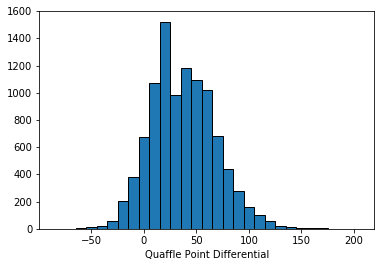

In [5]:
get_distribution(plsf,plsop,elos,p,s)

#### Potential Improvements

<ol>
    <li> Convert the function sim_game from taking p to taking a custom function to calculate probability of scoring during sop and during seeker floor to better have control of adjusting hyperparameters for optimal model selection </li>
    <li> Add a graphic visualization for SWIM games to help better see the interplay in the seeker game for in range games/ testing the efficacy of the seeking parameter</li>
    <li> Use USQ game data for parameter selection </li>
</ol>

In [13]:
def test_swim_params(sf,sop,elos,p,s):
    dset = [[x  for x in sim_game(sf,sop,elos,p,s)] for _ in range(10000) ]
    isr_18 = [g for g in dset if abs(g[2]-g[3])<=30] 
    print('{}% of games were in range at 18'.format(len(isr_18)/100))
    finished_isr = [g for g in isr_18 if abs(g[0]-g[1])<=60]
    print('{}% of games in range at 18 finished in range'.format(len(finished_isr)*100/len(isr_18)))
    won = [g for g in finished_isr if g[0]>g[1]]
    print('SWIM for team 1 was {}%'.format(len(won)*100/len(finished_isr)))

So for a 200 pt elo difference, with scoring rate at 55% and even snitch catch probability, we can test swim params. You should be seeing ~57% of games being in range at 18, ~81% of those games finishing in range, and a ~59% SWIM for the team with the higher elo. 

Why do you see such a difference despite even seeking skill? Well lets say team A has a 30 point lead coming into snitch on pitch play - with the score oscillating at +30, the weaker team is not actually attempting to go for the grab on every drive, only when the score dips to +20 every now and then. Thus we would expect SWIM to be slightly higher even w even seeking skill in these conditions.



In [19]:
test_swim_params(plsf,plsop,elos=(2000,1800),p=.55,s=(.125,.125))

57.37% of games were in range at 18
80.8262157922259% of games in range at 18 finished in range
SWIM for team 1 was 59.19775717058443%


In [21]:
test_swim_params(plsf,plsop,elos=(2000,1800),p=.55,s=(.105,.145))

56.5% of games were in range at 18
79.20353982300885% of games in range at 18 finished in range
SWIM for team 1 was 50.502793296089386%


In [22]:
test_swim_params(plsf,plsop,elos=(2000,2000),p=.55,s=(.105,.145))

84.11% of games were in range at 18
92.390916656759% of games in range at 18 finished in range
SWIM for team 1 was 41.59052888946081%


In [27]:
test_swim_params(plsf,plsop,elos=(2000,2000),p=.55,s=(.1,.2))

84.53% of games were in range at 18
93.30415237193895% of games in range at 18 finished in range
SWIM for team 1 was 32.96563966020033%


In [8]:
isr_dset = [g for g in dset if abs(g[2]-g[3])<=30]

In [10]:
len(isr_dset)/len(dset)

0.566